README


Project Description:
This project aims to implement a 3D scene reconstruction pipeline using images captured by a smartphone camera. The reconstruction process involves camera calibration, feature detection and matching, fundamental matrix estimation, triangulation, and 3D visualization. The main objective is to generate a coherent 3D point cloud of an object (laptop) and compare the performance of two feature detectors: SIFT and ORB.

Prerequisites:



To successfully run this project, you will need the following:
Python 3.7 or higher
Jupyter Notebook for executing the code
The following Python packages: OpenCV, NumPy, Matplotlib

You need to make sure you have the correct file structure as mine in your drive for clear run and face no errors.



As mentioned above we have some imports to make and other than these you should have no problem running the codes.

Have a nice day.

CALIBRATION PART


In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import cv2
import numpy as np
import glob
import matplotlib.pyplot as plt


In [3]:
# Calibration parameters
pattern_size = (10, 7)  # Number of internal corners (not squares)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# Prepare object points (3D coordinates)
objp = np.zeros((pattern_size[0] * pattern_size[1], 3), np.float32)
objp[:, :2] = np.mgrid[0:pattern_size[0], 0:pattern_size[1]].T.reshape(-1, 2)

# Arrays to store object points and image points
objpoints = []  # 3D points in real world space
imgpoints = []  # 2D points in image plane


In [4]:
# Define the image folder path (update if your folder name changes)
image_folder = '/content/drive/My Drive/EE417_TH3/Board/'

# Get all image file paths
images = glob.glob(image_folder + '*.jpeg')
print("Loaded image files:", images)


Loaded image files: ['/content/drive/My Drive/EE417_TH3/Board/Board3.jpeg', '/content/drive/My Drive/EE417_TH3/Board/Board1.jpeg', '/content/drive/My Drive/EE417_TH3/Board/Board2.jpeg', '/content/drive/My Drive/EE417_TH3/Board/Board8.jpeg', '/content/drive/My Drive/EE417_TH3/Board/Board4.jpeg', '/content/drive/My Drive/EE417_TH3/Board/Board5.jpeg', '/content/drive/My Drive/EE417_TH3/Board/Board6.jpeg', '/content/drive/My Drive/EE417_TH3/Board/Board7.jpeg', '/content/drive/My Drive/EE417_TH3/Board/Board12.jpeg', '/content/drive/My Drive/EE417_TH3/Board/Board9.jpeg', '/content/drive/My Drive/EE417_TH3/Board/Board10.jpeg', '/content/drive/My Drive/EE417_TH3/Board/Board11.jpeg', '/content/drive/My Drive/EE417_TH3/Board/Board13.jpeg', '/content/drive/My Drive/EE417_TH3/Board/Board16.jpeg', '/content/drive/My Drive/EE417_TH3/Board/Board14.jpeg', '/content/drive/My Drive/EE417_TH3/Board/Board15.jpeg']


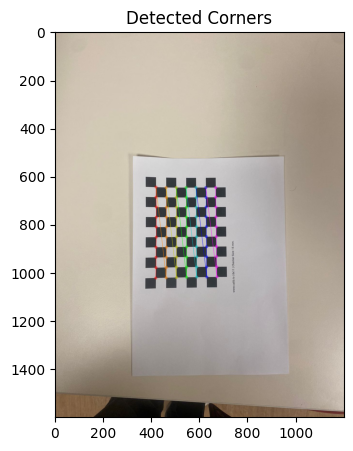

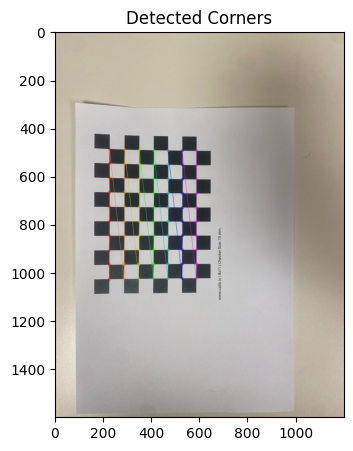

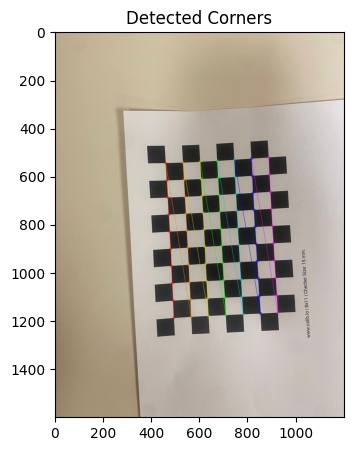

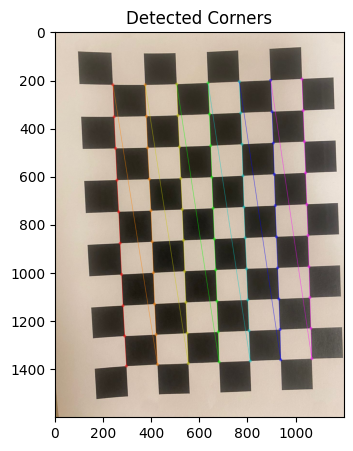

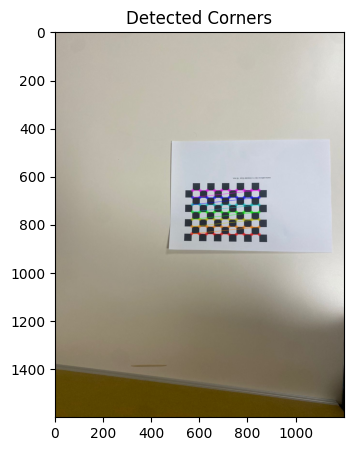

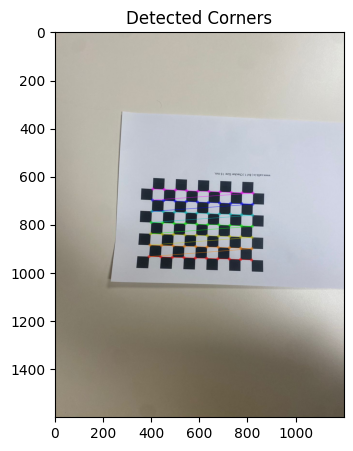

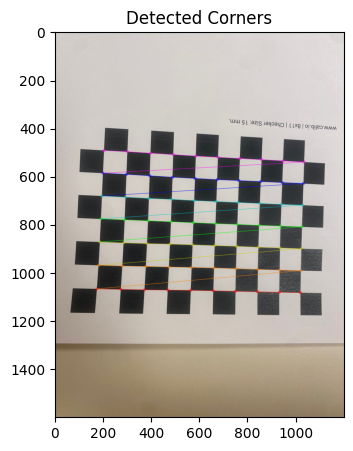

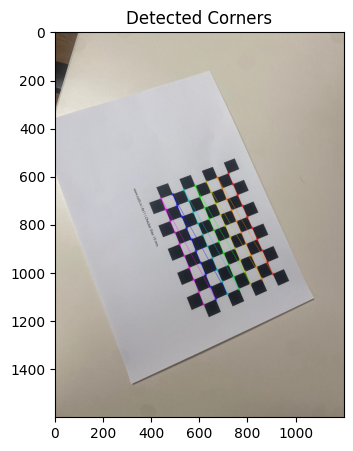

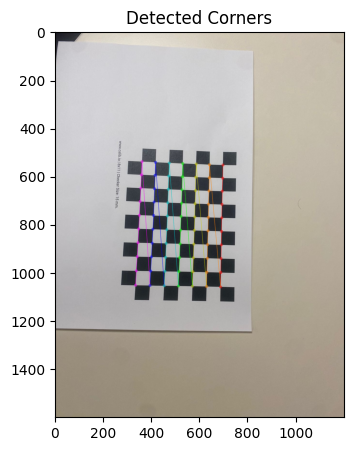

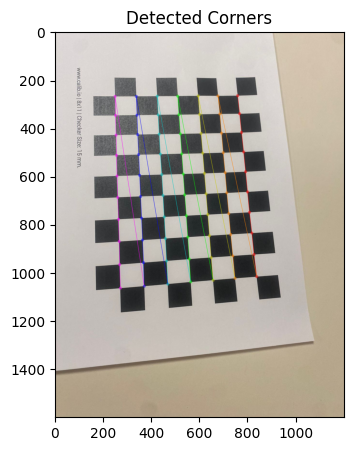

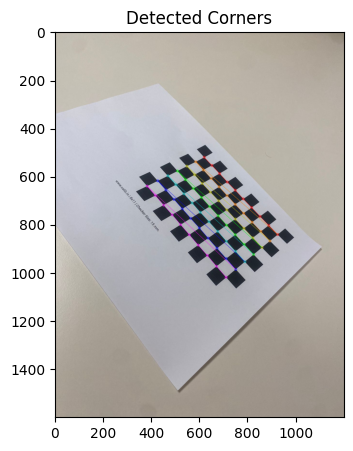

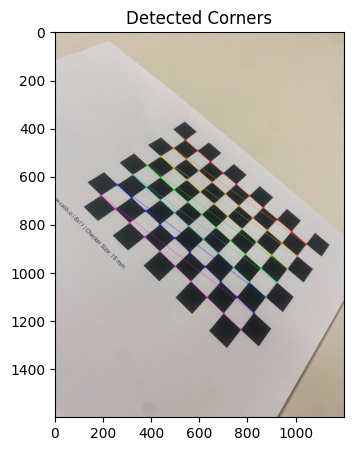

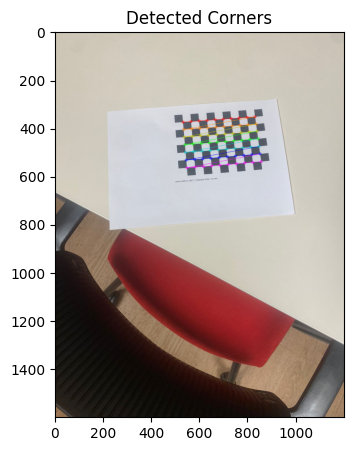

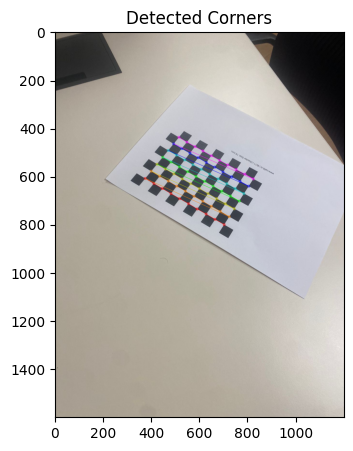

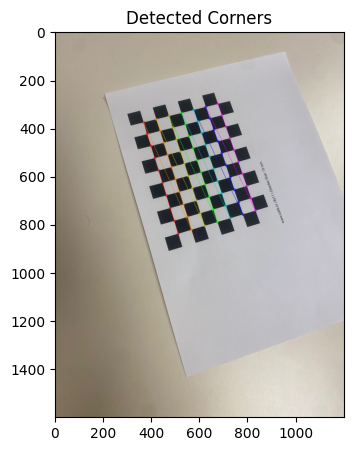

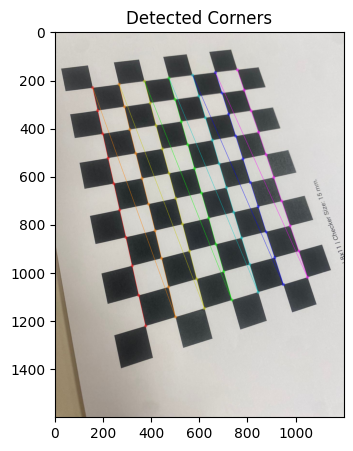

In [5]:
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, pattern_size, None)

    if ret:
        objpoints.append(objp)
        corners2 = cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)
        imgpoints.append(corners2)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, pattern_size, corners2, ret)
        plt.figure(figsize=(5, 5))
        plt.title('Detected Corners')
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.show()
    else:
        print(f"Corners not detected in: {fname}")


In [6]:
# Calibrate the camera
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

# Print calibration results
print("Camera matrix:\n", mtx)
print("Distortion coefficients:\n", dist)

# Save the calibration data to Google Drive
np.savez('/content/drive/My Drive/EE417_TH3/camera_calib_v3.npz', mtx=mtx, dist=dist, rvecs=rvecs, tvecs=tvecs)
print("Calibration data saved to Google Drive!")


Camera matrix:
 [[1.23316603e+03 0.00000000e+00 6.22488420e+02]
 [0.00000000e+00 1.23151825e+03 7.79543795e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Distortion coefficients:
 [[ 2.57093878e-01 -1.43004226e+00 -1.02061739e-03 -6.49017620e-04
   2.27491842e+00]]
Calibration data saved to Google Drive!


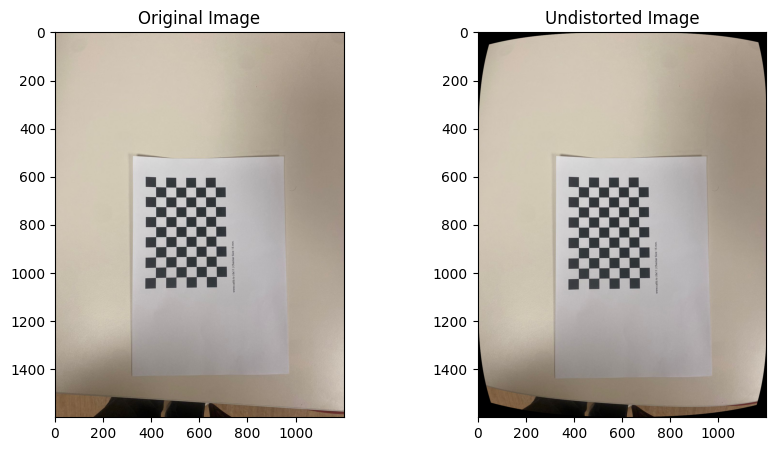

In [7]:
# Load one of the images to verify the calibration
test_image = cv2.imread(images[0])
h, w = test_image.shape[:2]
new_camera_mtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w, h), 1, (w, h))

# Undistort the image
undistorted = cv2.undistort(test_image, mtx, dist, None, new_camera_mtx)

# Display original and undistorted images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB))

plt.subplot(1, 2, 2)
plt.title("Undistorted Image")
plt.imshow(cv2.cvtColor(undistorted, cv2.COLOR_BGR2RGB))
plt.show()


In [8]:
# Load calibration data
calib_data = np.load('/content/drive/My Drive/EE417_TH3/camera_calib_v3.npz')
mtx = calib_data['mtx']
dist = calib_data['dist']
print("Loaded camera matrix:\n", mtx)
print("Loaded distortion coefficients:\n", dist)


Loaded camera matrix:
 [[1.23316603e+03 0.00000000e+00 6.22488420e+02]
 [0.00000000e+00 1.23151825e+03 7.79543795e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Loaded distortion coefficients:
 [[ 2.57093878e-01 -1.43004226e+00 -1.02061739e-03 -6.49017620e-04
   2.27491842e+00]]


IMAGE PART

In [9]:
# Load the previously saved calibration data
calib_data = np.load('/content/drive/My Drive/EE417_TH3/camera_calib_v3.npz')
mtx = calib_data['mtx']
dist = calib_data['dist']

print("Camera matrix:\n", mtx)
print("Distortion coefficients:\n", dist)


Camera matrix:
 [[1.23316603e+03 0.00000000e+00 6.22488420e+02]
 [0.00000000e+00 1.23151825e+03 7.79543795e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Distortion coefficients:
 [[ 2.57093878e-01 -1.43004226e+00 -1.02061739e-03 -6.49017620e-04
   2.27491842e+00]]


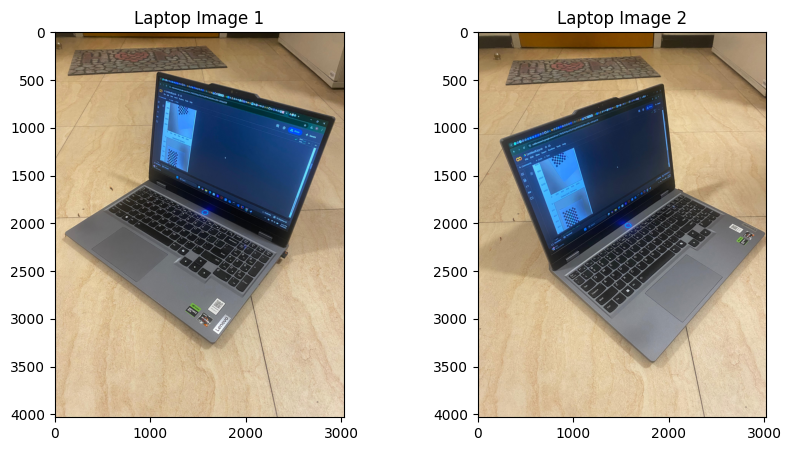

In [10]:
# Load the laptop images from your Google Drive
image1_path = '/content/drive/My Drive/EE417_TH3/Laptop/Laptop1.jpeg'
image2_path = '/content/drive/My Drive/EE417_TH3/Laptop/Laptop2.jpeg'

image1 = cv2.imread(image1_path)
image2 = cv2.imread(image2_path)

# Display the loaded images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Laptop Image 1")
plt.imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))

plt.subplot(1, 2, 2)
plt.title("Laptop Image 2")
plt.imshow(cv2.cvtColor(image2, cv2.COLOR_BGR2RGB))
plt.show()


In [11]:
# Initialize SIFT and ORB detectors
sift = cv2.SIFT_create()
orb = cv2.ORB_create()

# Detect keypoints and descriptors using SIFT
keypoints1_sift, descriptors1_sift = sift.detectAndCompute(image1, None)
keypoints2_sift, descriptors2_sift = sift.detectAndCompute(image2, None)

# Detect keypoints and descriptors using ORB
keypoints1_orb, descriptors1_orb = orb.detectAndCompute(image1, None)
keypoints2_orb, descriptors2_orb = orb.detectAndCompute(image2, None)

print(f"SIFT Keypoints: Image 1 = {len(keypoints1_sift)}, Image 2 = {len(keypoints2_sift)}")
print(f"ORB Keypoints: Image 1 = {len(keypoints1_orb)}, Image 2 = {len(keypoints2_orb)}")


SIFT Keypoints: Image 1 = 24161, Image 2 = 22821
ORB Keypoints: Image 1 = 500, Image 2 = 500


In [12]:
# BFMatcher for SIFT (using L2 norm)
bf_sift = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
matches_sift = bf_sift.match(descriptors1_sift, descriptors2_sift)
matches_sift = sorted(matches_sift, key=lambda x: x.distance)

# BFMatcher for ORB (using Hamming norm)
bf_orb = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches_orb = bf_orb.match(descriptors1_orb, descriptors2_orb)
matches_orb = sorted(matches_orb, key=lambda x: x.distance)

print(f"SIFT Matches: {len(matches_sift)}")
print(f"ORB Matches: {len(matches_orb)}")


SIFT Matches: 6958
ORB Matches: 149


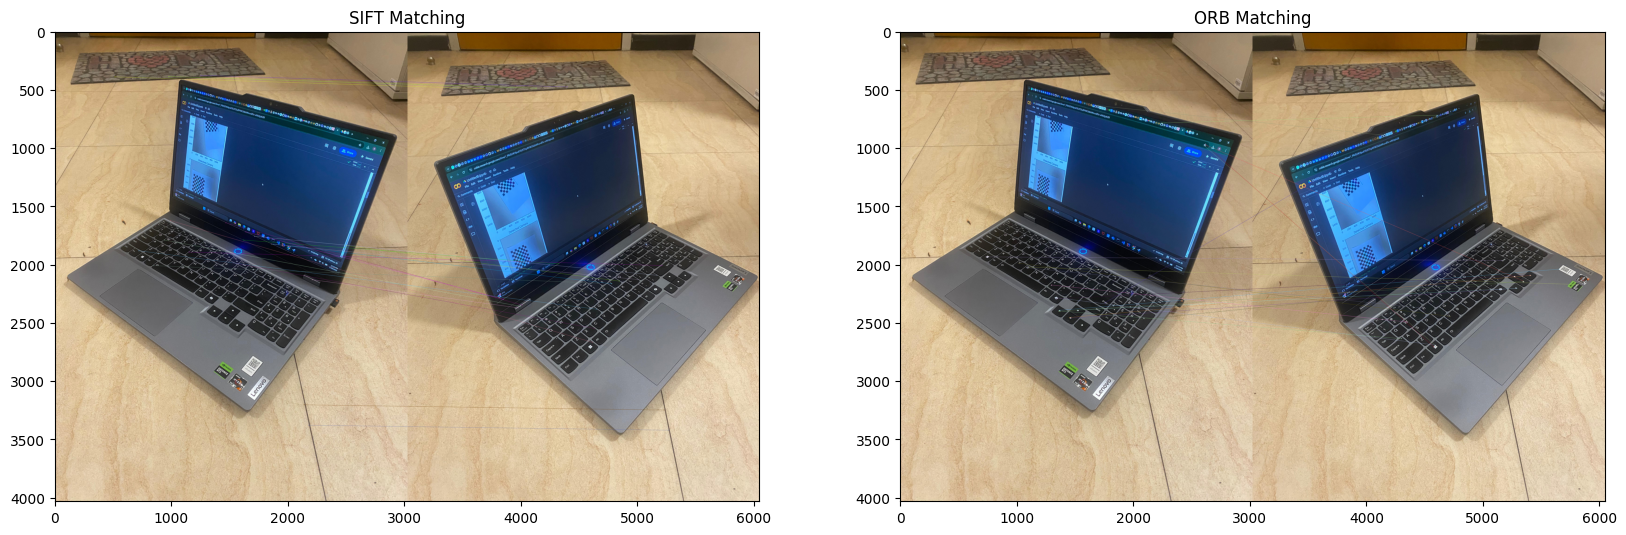

In [13]:
# Draw matches for SIFT
matched_sift = cv2.drawMatches(image1, keypoints1_sift, image2, keypoints2_sift, matches_sift[:20], None, flags=2)

# Draw matches for ORB
matched_orb = cv2.drawMatches(image1, keypoints1_orb, image2, keypoints2_orb, matches_orb[:20], None, flags=2)

# Plot the matches
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.title("SIFT Matching")
plt.imshow(cv2.cvtColor(matched_sift, cv2.COLOR_BGR2RGB))

plt.subplot(1, 2, 2)
plt.title("ORB Matching")
plt.imshow(cv2.cvtColor(matched_orb, cv2.COLOR_BGR2RGB))

plt.show()


In [14]:
def compute_reconstruction_quality(matches, keypoints1, keypoints2):
    # Extract point coordinates from matches
    pts1 = np.float32([keypoints1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    pts2 = np.float32([keypoints2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

    # Calculate the fundamental matrix
    F, mask = cv2.findFundamentalMat(pts1, pts2, cv2.FM_RANSAC)

    # Calculate the number of inliers (good matches)
    inliers = np.sum(mask)
    accuracy = inliers / len(matches) * 100
    return accuracy

sift_accuracy = compute_reconstruction_quality(matches_sift, keypoints1_sift, keypoints2_sift)
orb_accuracy = compute_reconstruction_quality(matches_orb, keypoints1_orb, keypoints2_orb)

print(f"SIFT Matching Accuracy: {sift_accuracy:.2f}%")
print(f"ORB Matching Accuracy: {orb_accuracy:.2f}%")


SIFT Matching Accuracy: 16.77%
ORB Matching Accuracy: 8.05%


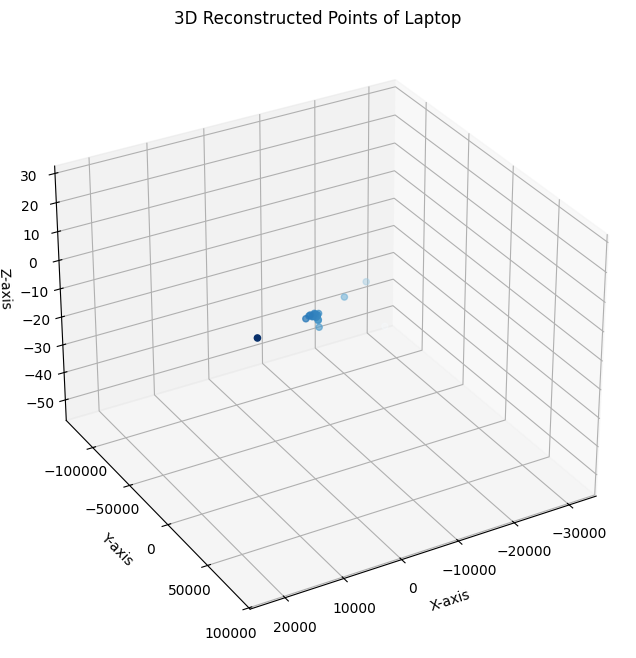

In [19]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Load the saved 3D points from Google Drive
points3D = np.load('/content/drive/My Drive/EE417_TH3/Laptop/3D_points.npy')

# Create the 3D scatter plot
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot with larger markers and enhanced color coding
ax.scatter(points3D[0], points3D[1], points3D[2], c=points3D[2], cmap='Blues', marker='o', s=20)

# Set titles and labels
ax.set_title("3D Reconstructed Points of Laptop")
ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")
ax.set_zlabel("Z-axis")

# Customize the view angle for better perception
ax.view_init(elev=30, azim=60)

plt.show()
